# Human in the Loop Mini Lab

### Hung Tran

## Background: The Task and Its Challenges

For this lab, we will build upon the simple image classification mini lab with a new dataset and a task that's directly relevant to your professor's research. Our dataset is a random sample of scanned page images from _The Comics Journal_, an American magazine of news and criticism pertaining to comic books, comic strips and graphic novels published in one form or another since 1976. Using rule-based methods (dilating, thresholding, edge detection, etc.) I converted these page images into smaller segments, each one theoretically representing "a block of content" on a page surrounded by white space. Some of these blocks are very clear chunks of magazine text, such as a paragraph or an entire column, and some of them are illustrations, advertisements, comic strips, etc. Lastly, there are many things that we might think of as errors, where a partitioned shape was identified but it's actually two separate blocks or part of a larger image that wasn't recognized. Associate Professor of Philosophy Sam Cowling and I are writing an article about _The Comics Journal_ related to the way certain comics are discussed and analyzed, so this project is a spin-off of that work. Our goal is to sort image segments into two categories: segments where only text appears in the image, an segments where anything besides text appears, even if the image is mostly text. 

### Question 1

Before we start, write some code using our openCV workflow and matplotlib to display three example images: `train_test/April_1986_107_1003063041-i0095_0_8.jpg`, `train_test/December_1997_200_1003063118-i00264_2.jpg`, and `train_test/December_1999_218_1003063135-i00094_6.jpg`. Don't forget to display the RGB versions!

Below your code chunk, describe how you would categorize each of these image segments and why.

In [ ]:
import cv2 
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import ndimage
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [48]:
image1 = cv2.imread('train_test/October_2002_247_1003063164-i00020_11.jpg')
image2 = cv2.imread('train_test/October_1997_199_1003063117-i00121_5.jpg')
image3 = cv2.imread('train_test/October_2007_285_1003063199-i00139_9.jpg')

Text(0.5, 1.0, 'Third Image')

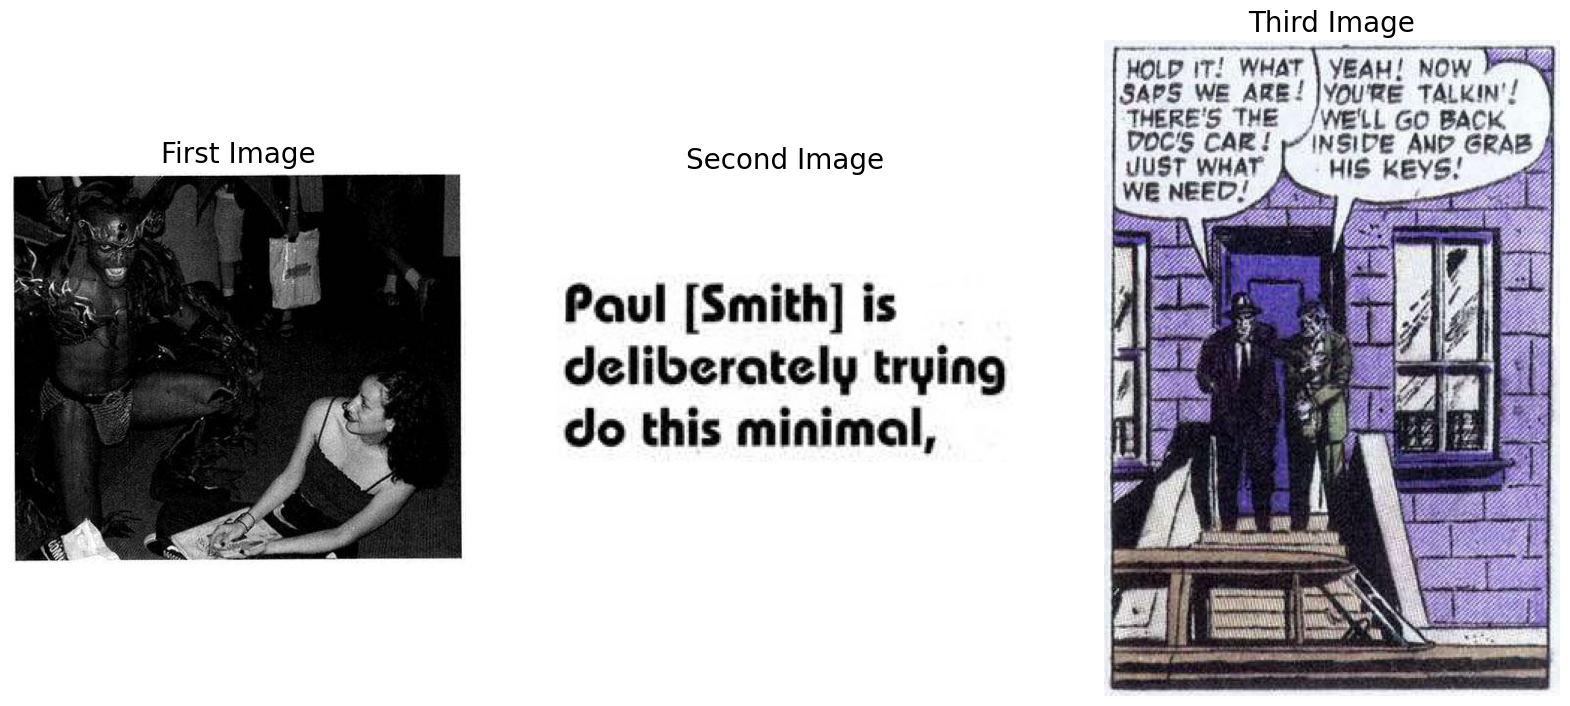

In [49]:
fig = plt.figure(figsize=(20, 30))

rows = 1
columns = 3

#Displaying the first image
fig.add_subplot(rows, columns, 1)
plt.imshow(image1)
plt.axis('off')
plt.title("First Image", size = 20)

#Displaying the second image
fig.add_subplot(rows, columns, 2)
plt.imshow(image2)
plt.axis('off')
plt.title("Second Image\n\n\n", size = 20)

#Displaying the third image
rgb_3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
fig.add_subplot(rows, columns, 3)
plt.imshow(rgb_3)
plt.axis('off')
plt.title("Third Image", size = 20)



The reason why I chose these 3 images is because they can be categorized in 3 different ways. The first image is the photo with no textt, the second one is pure text, and the third one is a mix between text and non-text elements. One of the keys problem with images is that between text and non-text elements, the computer vision will identify differently based on the pixels scores. While text images have lots of black and white pixels (1-dimension score), the non-text images tend to have RGB scores (3-dimension scores). This is easier for computer to differentiate those 2 groups apart. The third group is harder for computer since they have a mixture between text and non-text elements. Therefore, those images should be put in 1 particular group.

## Background: The Importance of Folder Locations

Before we start, let's look at how your professor has set up your Github repo. (It turns out, I made some fairly specific decisions, and he had reasons for doing so.) In HITL of Active Learning, there's an emphasis on simple labeling interfaces that do the following:

- Cast your problems as binary choices wherever possible.
- Ensure that expected responses are diverse to avoid priming.
- Use existing interaction conventions.
- Allow keyboard-driven responses. (16)

For this mini lab, we don't have time to build a web interface, but our task is simple enough that we can use our file system as a minimal labeling interface. Our unlabeled data is already divided into a `train_test` folder and an `evaluate` folder. None of our data are labeled, but we've set aside the `evaluate` data before labeling, as Monarch recommends, because "there are many ways to inadvertently bias your evaluation data after you have started other sampling techniques" (41). As we go through the images, we will "label" them by moving them to folder locations that describe their category. Since we are trying to presort the data into images of "all text" and images with anything besides text, we can call our folders `only_text_block` and `not_only_text_block`. We can identify which category an image belongs to and move it to a new location very quickly (I did 200 as a test and completed the batch in about 10 minutes). Using this method, however, we need a way to put all of the selected images into one folder called something like `to_label`, and then we need to stop at the end of each iteration and record what we selected and why. And we need to do these two things for each iteration so we we can trace the gradual improvement (or not) of our model. 

### Question 2

Before doing anything else, let's create a root-level folder called `to_label` with two subfolders called `only_text_block` and `not_only_text_block`. Now let's write a function that can collect the names of every image file in each of these subfolders, and save the file names and their subfolders to a CSV file called `iteration-1.csv`, `iteration-2.csv`, etc. For convenience, let's call this function `track_iterations`.

In [50]:
from pathlib import Path
import pandas as pd

In [52]:
os.mkdir("to_label")
os.mkdir("to_label/only_text_block")
os.mkdir("to_label/not_only_text_block")

In [3]:
def track_iterations(directory, output_filename):
    df_track = pd.DataFrame(columns = ['file_name', 'label'])
    files_0 = os.listdir(f'{directory}/not_only_text_block')
    files_1 = os.listdir(f'{directory}/only_text_block')
    for fname in files_0:
        if 'jpg' in fname:
            df_track = df_track.append({'file_name':fname, 'label': 0}, ignore_index = True)
    for fname in files_1:
        if 'jpg' in fname:
            df_track = df_track.append({'file_name':fname, 'label': 1}, ignore_index = True)
    df_track.to_csv(f'{output_filename}.csv', index = False)
    

## Iteration 1

Since we have no labels, we need to ask what is a big enough sample for our initial model? In the book we read, the HITL example starts with 100 labeled text documents for each class label. We don't know the underlying class balance of our data, but we should be able to annotate 200 images fairly quickly. Since we don't have any information about the images, we should start with a random selection.

### Question 3

Write function to select 200 random images from the `train_test` folder and move them to the `to_label` folder that you created. We're moving them instead of copying them because we don't want to select any duplicates in a later iteration. For convenience, let's call this function `select_and_move_images`.

In [54]:
import random

In [55]:
def select_and_move_images(src_folder, dest_folder, sample_size):
    file_list = random.sample(os.listdir(f'{src_folder}'), sample_size)
    for fname in file_list:
        try:
            os.rename(f'{src_folder}/{fname}', f'{dest_folder}/{fname}')
        except:
            pass

In [56]:
select_and_move_images('train_test', 'to_label', 200)

Now we need to label our 200 images. Outside of your Jupyter Notebook, open up the `to_label` folder and look at the images in it. On most computers, you can change your view settings from `list` or `columns` to `icons` or `gallery` so that you can see a preview of each image. As you glance at them, it should be obvious for most of them which images are all text and which images aren't. As you identify them, simply drag each image to the correct subfolder, `only_text_block` or `not_only_text_block`. If you have a hard time classifying an image, open it in Preview, Adobe, etc. and give it a closer look. 

### Question 4

Once we've labeled 200 images by moving them to subfolders, we need to use our `track_iterations` function from above to capture which items we labeled and what their labels are. Write a chunk of code below that captures this information and saves the result as `iteration-1.csv`. 

In [4]:
track_iterations('to_label', 'iteration-1')

NameError: name 'pd' is not defined

### Question 5

Now we also need to stop and estimate at our class balancing, as our next rounds of annotation will not be random samples. Write some code to count how many images of each class we have, and to estimate the ratio of `only_text_block` segments to `not_only_text_block` segments. Lastly, how can we write our function to estimate the sampling error of this ratio? Make sure your code displays the ratio estimate and the estimated sampling error below. For convenience, let's call this function `estimate_class_weights`.

In [58]:
def estimate_class_weights(folder_only_text, folder_not_only_text):
    #Get the binary labels for the lengths of each os.listdir list for all the documents within 2 categories
    binary_list = [1 for i in range(len(folder_only_text))] + [0 for i in range(len(folder_not_only_text))]
    #Critical value or multiplier for 95% conf
    z=1.96
    n_ratio = len(folder_only_text)/len(binary_list)
    folder_ratio = len(folder_only_text)/len(folder_not_only_text)
    sample_error = (np.sqrt(z*n_ratio*(1-n_ratio)))*10
    return folder_ratio, sample_error


### Question 6

Finally, we can train and test our first machine learning model. In the basic image classification mini lab, the `white_pixel_ratio` score seemed to work pretty well for this task, but will it generalize? Using our opencv and scikit-learn workflow from the mini lab, do the following:

1. load the 200 images for which we have labels
2. create a train/test split of the data
3. train a logistic regression model
4. evaluate its performance by looking at the precision, recall, and f1 scores for both classes 
5. make sure your code block below prints all of your performance benchmarks

In [59]:
def white_black_ratio(image_threshed):
    total = sum([len(i) for i in image_threshed])
    white = 0
    for i in image_threshed:
        for j in i:
            if j == 0:
                white +=1
    return white/total

In [77]:
#Load the 200 images
files_only_text = glob.glob('to_label/only_text_block/*.jpg')
files_not_only_text = glob.glob('to_label/not_only_text_block/*.jpg')

In [78]:
# Create a train/test split of the data_Step1: Converting images into gray scale 
only_text_white_ratios = []
not_only_text_white_ratios = []
threshed_all = []
imgs_all = []

for i in files_only_text:

        img_only_text = cv2.imread(i)
        rgb_only_text = cv2.cvtColor(img_only_text, cv2.COLOR_BGR2RGB)
        gray_only_text = cv2.cvtColor(rgb_only_text, cv2.COLOR_BGR2GRAY)
        th, threshed_only_text = cv2.threshold(gray_only_text, 128, 255, cv2.THRESH_BINARY)
        wb_score_only_text = white_black_ratio(threshed_only_text)
        only_text_white_ratios.append(wb_score_only_text)

for k in files_not_only_text:
        img_not_only_text = cv2.imread(k)
        rgb_not_only_text = cv2.cvtColor(img_not_only_text, cv2.COLOR_BGR2RGB)
        gray_not_only_text = cv2.cvtColor(rgb_not_only_text, cv2.COLOR_BGR2GRAY)
        th, threshed_not_only_text = cv2.threshold(gray_not_only_text, 128, 255, cv2.THRESH_BINARY)
        wb_score_not_only_text = white_black_ratio(threshed_not_only_text)
        not_only_text_white_ratios.append(wb_score_not_only_text)

In [79]:
# Create a train/test split of the data_Step2: Marking binary labels 
image_white_ratios = [y for x in [only_text_white_ratios, not_only_text_white_ratios] for y in x]
label_binary = [1 for i in range(len(only_text_white_ratios))]
label_binary += [0 for i in range(len(not_only_text_white_ratios))]

In [80]:
#apply train_test_split to separate the data for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(image_white_ratios), label_binary, test_size=0.3, random_state=17)

In [81]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced', random_state=25).fit(X_train.reshape(-1,1), y_train)
prediction = lr.predict(X_test.reshape(-1, 1))
predict_probs = lr.predict_proba(X_test.reshape(-1, 1))

In [82]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.94      0.98      0.96        50

    accuracy                           0.93        60
   macro avg       0.91      0.84      0.87        60
weighted avg       0.93      0.93      0.93        60



### Question 7

While we're here, let's just write some code to load all the images remaining in the `train_test` folder (using our opencv workflow from the basic image classification mini lab), calculate their `white_pixel_ratio` scores, and save the ratios as a `ratio_dictionary` so that we can look up any `white_pixel_ratio` using only an image's file name. We can also save these file names and ratios to a CSV file, which will come in handy if we need to restart our Jupyter Notebook!

In [71]:
other_images = glob.glob('train_test/*.jpg')
ratio_dictionary= {}

for i in other_images:
    img = cv2.imread(i)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    wb_score_other = white_black_ratio(threshed)   
    ratio_dictionary[i] = wb_score_other

df_dict = pd.DataFrame.from_dict(ratio_dictionary.items())
df_dict.to_csv('ratio_dictionary.csv', index=False)

## Iteration 2

We have a model and a benchmark! It's time to see if active learning can help us "specify how you elicit training data from people and determine the right data to put in front of people when you don't have the budget or time for human feedback on all your data" (4). To make use of active learning strategies, we will create new batches of images to label based on uncertainty sampling, diversity sampling, and a bit of random chance so that "every data item still has some chance of being selected randomly and being reviewed by a human, even if none of the sampling strategies would have selected it" (44). In the book, Monarch recommends each iteration be composed of: 

- 10% randomly selected from unlabeled items
- 80% selected from the lowest confidence items
- 10% selected as outliers

In a batch of 200 images, we will have 20 randomly selected segment images, 20 identified as outliers, and 160 of our lowest confidence items after making predictions. To employ these three strategies, we need:

- a function to create a random sample of images from `train_test` and move them to `to_label`, but we already have the `select_and_move_images` function from our first iteration. We just need to make sure our function can accept a sample size as an argument since our sample size here will be 20, not 200.
- a way to load all the images left in `train_test`, look up their `white_pixel_ratio` scores from your `ratio_dictionary`, and use those scores to predict the probability that each image is an `only_text_block` segment, and to move the most ambiguous 160 images to the `to_label` folder.
- a way to identify outliers in the data and move the 20 most significant outliers to the `to_label` folder.

### Question 8

Use your `select_and_move_images` function to select 20 image at random from `train_test` and move them to the `to_label` folder.

In [87]:
select_and_move_images('train_test', 'to_label', 20)

### Question 9

Write some code that looks up all relevant `white_pixel_ratio` values using your `ratio_dictionary`, use these scores to predict the probability that each image is an `only_text_block` segment, and move the most ambiguous 160 images to the `to_label` folder. 

In [73]:
df_white = pd.DataFrame()
df_white = df_dict.copy()
df_white.columns = ['file_name' , 'ratio']
df_white.sort_values('ratio', ascending=True, inplace=True)

#Calculate the median
median = np.median(df_white['ratio'])
df_white['distance_from_mid'] = abs(df_white['ratio'] - median)
df_white.sort_values('distance_from_mid', ascending=True, inplace=True)

In [74]:
images_160 = df_white.head(160)
images_160

,file_name,ratio,distance_from_mid
322,train_test/February_1992_148_1002796200-i00063...,0.137575,0.000004
309,train_test/March_1992_149_1003063077-i00074_6.jpg,0.137584,0.000004
598,train_test/November_2000_228_1003063145-i00047...,0.137563,0.000016
794,train_test/February_1991_140_1003063072-i00073...,0.137557,0.000022
177,train_test/January_1998_201_1003063119-i00037_...,0.137529,0.000050
...,...,...,...
823,train_test/October-November_2004_263_100306317...,0.144534,0.006954
1156,train_test/November_1999_217_1003063134-i00114...,0.144581,0.007001
674,train_test/May_1998_204_1003063121-i00095_1.jpg,0.130545,0.007035
597,train_test/December_1997_200_1003063118-i00084...,0.144621,0.007041


In [83]:
for i in images_160['file_name']:
    name_160 = i.split('test/')[1]
    os.rename(i, f'to_label/{name_160}')

### Question 10 

Write some code that finds outliers among the images remaining in the `train_test` folder. To isolate outliers, we can start by finding a mix of images that have `white_pixel_ratio` scores that weren't in our original sample, whether that's very high scores, very low scores, or scores that fall between gaps in our `iteration-1` dataset. Using any mix of these methods, select 25 outliers and move them to the `to_label` folder.

[Text(0.5, 0, 'White Pixel Ratio'), Text(0, 0.5, 'Frequency')]

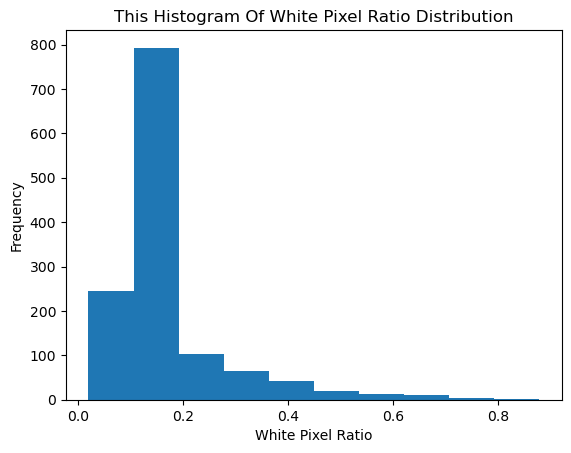

In [84]:
ax = df_white['ratio'].plot(kind='hist', title='This Histogram Of White Pixel Ratio Distribution')
ax.set(xlabel="White Pixel Ratio", ylabel="Frequency")

Based on the Histogram of White Pixel Ratio distribution, we can see that this is a right-skewed distribution, which means that the outliers are the ones having highest scores. As a result, we will choose top 20 images having the highest scores.

In [85]:
df_white.sort_values('ratio', ascending=False, inplace=True)
top20 = df_white.head(20)
top20 

,file_name,ratio,distance_from_mid
128,train_test/October_2002_247_1003063164-i00020_...,0.879030,0.741451
195,train_test/February-March_2005_266_1003063182-...,0.813574,0.675994
409,train_test/February_2004_258_1003063174-i00004...,0.757756,0.620177
846,train_test/November_1980_60_1002857616-i0016_1...,0.750997,0.613418
944,train_test/April_1996_186_1003063106-i00018_11...,0.747689,0.610109
318,train_test/October-November_2004_263_100306317...,0.713785,0.576206
368,train_test/April_1998_203_1003063120-i00100_10...,0.709660,0.572081
583,train_test/June_2003_253_1002856570-i00030_10.jpg,0.697681,0.560102
741,train_test/October_1999_216_1003063133-i00020_...,0.684534,0.546954
1279,train_test/April_1996_186_1003063106-i00018_12...,0.668499,0.530919


In [86]:
for i in top20['file_name']:
    name = i.split('t/')[1]
    os.rename(i, f'to_label/{name}')

### Question 11

As with Iteration 1, we need to label all the data in our `to_label` folder by moving it to the appropriate subfolder. When that process is complete, we can use the `track_iterations` function from above to capture all file names found in the `train_test` subfolders, as well as how they should be labeled. Call your `track_iterations` function below save the CSV as `iteration-2.csv`

In [95]:
track_iterations('to_label', 'iteration-2')

/var/folders/2r/g4vkysnx2xsdc5q9gb75z9v40000gn/T/ipykernel_14712/3700946121.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_track = df_track.append({'file_name':fname, 'label': 0}, ignore_index = True)
/var/folders/2r/g4vkysnx2xsdc5q9gb75z9v40000gn/T/ipykernel_14712/3700946121.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_track = df_track.append({'file_name':fname, 'label': 0}, ignore_index = True)
/var/folders/2r/g4vkysnx2xsdc5q9gb75z9v40000gn/T/ipykernel_14712/3700946121.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_track = df_track.append({'file_name':fname, 'label': 0}, ignore_index = True)
/var/folders/2r/g4vkysnx2xsdc5q9gb75z9v40000gn/T/ipykernel_14712/3700946121.py:7: FutureWarning: The frame

In [96]:
estimate_class_weights('to_label/only_text_block', 'to_label/not_only_text_block')

(0.8571428571428571, 6.9792592136700025)

### Question 12

Repeating all of the steps from Question 6, train and test your machine learning model using the now 400 images for which we have labels. Create a train/test split of the data, train a logistic regression model, evaluate its performance by looking at the precision, recall, and f1 scores for both classes, and make sure your code block below prints all of your performance benchmarks.

In [97]:
import glob 

In [98]:
#Load the 400 images
files_only_text_400 = glob.glob('to_label/only_text_block/*.jpg')
files_not_only_text_400 = glob.glob('to_label/not_only_text_block/*.jpg')

In [100]:
# Create a train/test split of the data_Step1: Converting images into gray scale 
only_text_white_ratios_400 = []
not_only_text_white_ratios_400 = []

for i in files_only_text_400:

        img_only_text_400 = cv2.imread(i)
        rgb_only_text_400 = cv2.cvtColor(img_only_text_400, cv2.COLOR_BGR2RGB)
        gray_only_text_400 = cv2.cvtColor(rgb_only_text_400, cv2.COLOR_BGR2GRAY)
        th, threshed_only_text_400 = cv2.threshold(gray_only_text_400, 128, 255, cv2.THRESH_BINARY)
        wb_score_only_text_400 = white_black_ratio(threshed_only_text_400)
        only_text_white_ratios_400.append(wb_score_only_text_400)

for k in files_not_only_text_400:
        img_not_only_text_400 = cv2.imread(k)
        rgb_not_only_text_400 = cv2.cvtColor(img_not_only_text_400, cv2.COLOR_BGR2RGB)
        gray_not_only_text_400 = cv2.cvtColor(rgb_not_only_text_400, cv2.COLOR_BGR2GRAY)
        th, threshed_not_only_text_400 = cv2.threshold(gray_not_only_text_400, 128, 255, cv2.THRESH_BINARY)
        wb_score_not_only_text_400 = white_black_ratio(threshed_not_only_text_400)
        not_only_text_white_ratios_400.append(wb_score_not_only_text_400)

In [123]:
image_white_ratios_400 = [y for x in [only_text_white_ratios_400, not_only_text_white_ratios_400] for y in x]
label_binary_400 = [1 for i in range(len(only_text_white_ratios_400)) ]
label_binary_400 += [0 for i in range(len(not_only_text_white_ratios_400))]

In [124]:
X_train_400, X_test_400, y_train_400, y_test_400 = train_test_split(np.array(image_white_ratios), label_binary, test_size=0.3, random_state=29)

In [125]:
lr_400 = LogisticRegression(class_weight='balanced', random_state=19).fit(X_train_400.reshape(-1,1), y_train_400)
prediction_400 = lr_400.predict(X_test_400.reshape(-1, 1))
predict_probs_400 = lr_400.predict_proba(X_test_400.reshape(-1, 1))

In [126]:
print(classification_report(y_test_400, prediction_400))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        14
           1       0.94      0.98      0.96        46

    accuracy                           0.93        60
   macro avg       0.93      0.88      0.90        60
weighted avg       0.93      0.93      0.93        60



### Question 13

Normally, we'd do a few more iterations and see where we are around the 800-1000 images mark, but this is a mini lab! Instead, let's consider an alternative method for isolating outliers in our data. One thing Monarch talks about is training a completely different model to do the same task, and then isolating the outliers from that model. Knowing what we know about `scikit-learn`, `opencv`, and `tensorflow`, describe an approach we could take to employ this strategy. be specific about the kind of model, how we would define/isolate outliers, and what kinds of outliers your choice of model might find.


From the lap, we have applied the black_white ratio to differentiate the classes of images (whether or not the image only contains texts). Another the way that we can utilize using opencv is Area detection using **convexHull** method. First, we conduct the similiar random sampling method like the begining of this labs. Using our own human annotation of whether an image has only text elements or not, we then use `opencv` package to find the contours (`cv2.findContours`). The following step will involve calculating the total areas of rectangular 2D boxes existing within the images. After this stage, we can use cv2_convexHull to detect the detect the areas easier and the resulting areas are also becoming a predictive factor (similar to white_black_ratios). We than calculating the ratio between the areas inside the bounding convex hull and the total area of the whole image.
After making the correlation table of contouring area ratio with each image, the outlier will be detected by the distribution of this ratio. The outlier in this situation is the one with both text elements and non-text elements since they have higher ratio of areas inside and outside the bounding convex Hull. This is also the image population that computer is found most struggling with in identifying the images. If we can separate this group and put them into the training model, the rate of detecting correct groups of images will increase.

## Evaluation

### Question 14

Our last step is to train our model on all of our labeled data and test it on the data in the `evaluation` folder. Repeating all of the steps from Question 6, train and test your machine learning model using the now 400 images for which we have labels, but do not create a train/test split of the data. Instead, train your logistic regression model on all 400 images, use the `.predict()` method to make predictions for all images in the `evaluation` folder, and evaluate performance by looking at the precision, recall, and f1 scores for both classes. Make sure your code block below prints all of your performance benchmarks. When you instantiate your logistic regression model, assume an initial class balancing equal to our estimate from our `estimate_class_weights` function from above. 

In [128]:
#As we have gone through the process of question 6 and 12, we will use the same variables from previous questions
#Trained Model:
X_evaluate = np.array(image_white_ratios_400)
Y_evaluate = label_binary_400
lr_evaluate = LogisticRegression(class_weight='balanced', random_state=11).fit(X_evaluate.reshape(-1,1), Y_evaluate)

In [129]:
files_only_text_evaluate = glob.glob('evaluate/only_text_block/*.jpg')
files_not_only_text_evaluate = glob.glob('evaluate/not_only_text_block/*.jpg')

In [130]:
only_text_white_ratios_evaluate = []
not_only_text_white_ratios_evaluate = []

for i in files_only_text_evaluate:
        img_eval = cv2.imread(i)
        rgb_eval = cv2.cvtColor(img_eval, cv2.COLOR_BGR2RGB)
        gray_eval  = cv2.cvtColor(rgb_eval , cv2.COLOR_BGR2GRAY)
        th, threshed_eval  = cv2.threshold(gray_eval , 128, 255, cv2.THRESH_BINARY)
        wb_score_eval  = white_black_ratio(threshed_eval)
        only_text_white_ratios_evaluate.append(wb_score_eval)

for k in files_not_only_text_evaluate:
        img_eval  = cv2.imread(k)
        rgb_eval  = cv2.cvtColor(img_eval, cv2.COLOR_BGR2RGB)
        gray_eval  = cv2.cvtColor(rgb_eval, cv2.COLOR_BGR2GRAY)
        th, threshed_eval = cv2.threshold(gray_eval, 128, 255, cv2.THRESH_BINARY)
        wb_score_eval  = white_black_ratio(threshed_eval)
        not_only_text_white_ratios_evaluate.append(wb_score_eval)


In [131]:
#Constructing X & Y for test/evaluation process
image_white_ratios_evaluate = [y for x in [only_text_white_ratios_evaluate, not_only_text_white_ratios_evaluate] for y in x]
label_binary_evaluate = [1 for i in range(len(only_text_white_ratios_evaluate)) ]
label_binary_evaluate += [0 for i in range(len(not_only_text_white_ratios_evaluate))] 

In [132]:
#Test Model:
X_test_evaluate = np.array(image_white_ratios_evaluate)
Y_test_evaluate = label_binary_evaluate
prediction_evaluate = lr.predict(X_test_evaluate.reshape(-1, 1))

In [133]:
print(classification_report(Y_test_evaluate, prediction_evaluate))

              precision    recall  f1-score   support

           0       0.82      0.56      0.67        59
           1       0.84      0.95      0.89       141

    accuracy                           0.83       200
   macro avg       0.83      0.75      0.78       200
weighted avg       0.83      0.83      0.82       200



### Question 15 

Interpret your model's performance below, as well, as how it changed over the course of the lab. Were our active learning strategies successful? Why or why not? 

For my model, I believe the results it conducted is solid based on the precision, around 82% - 84%. The recall score for text images are high, at 95%, but it's only 56% for the not-only-text images. This group contains multiple images that have both text and non-text element, so for computer to classify them as not a not-only-text images is understandable right after 2 simpl training setup. Based on the results, I believe our active learning strategies is successful because the way we set up sample size is efficient to the computer to run through and recognize the type of images. Nonetheless, based on the re-call score of not-only-text image group, we can see that the active learning strategies has not yet been perfect in the sense of identifying non-text element. Therefore, my recommendation for the next step of active learning set-up will be to focus more on non-text elements as the main image taxonomy. By doing this way, we can have a general picture of the results, which later on makes the computer learns in a different facade of the data.